In [1]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    classification_report,
    confusion_matrix)

In [2]:
#check gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU:", gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Cant find GPU, use CPU.")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'

#for root, dirs, files in os.walk(data_dir):
#    print(root, len(files), 'files')

In [ ]:
hermorrhage_png = glob.glob(os.path.join(data_dir, 'Kanama/PNG/*.png'))
ischemia_png = glob.glob(os.path.join(data_dir, 'İskemi/PNG/*.png'))
no_stroke_png = glob.glob(os.path.join(data_dir, 'İnme Yok/*.png')) 

images = []
labels = []

for img_path in hermorrhage_png:
    images.append(img_path)
    labels.append(1)  

for img_path in ischemia_png:
    images.append(img_path)
    labels.append(1) 

for img_path in no_stroke_png:
    images.append(img_path)
    labels.append(0) 

print(f"Count images: {len(images)}")
print(f"Count labels: {len(labels)}")

Count images: 6774
Count labels: 6774


In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 1
EPOCHS = 100

In [8]:
data_df = pd.DataFrame({
    'filename': images,
    'class': labels
})
data_df['class'] = data_df['class'].astype(str) 

train_df, val_df = train_test_split(
    data_df,
    test_size=0.20, 
    stratify=data_df['class'], 
    random_state=42  
)

In [9]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    return image

def configure_for_performance(ds, batch_size):
    ds = ds.cache() 
    ds = ds.shuffle(buffer_size=1000) 
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE) 
    return ds

def create_dataset_val_test(df, batch_size):
    list_ds = tf.data.Dataset.from_tensor_slices((df['filename'].values, df['class'].astype(int).values))

    ds = list_ds.map(lambda filename, label: (parse_image(filename), tf.cast(label, tf.float32)),
                     num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.cache() 
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [10]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))

In [11]:
def map_train_basic(filename, label, weight):
    image = parse_image(filename)
    label = tf.cast(label, tf.float32)
    weight = tf.cast(weight, tf.float32)
    return image, label, weight

def get_sample_weights(labels, class_weight_mapping):
    weights = np.ones(len(labels))
    for i, label in enumerate(labels):
        if label in class_weight_mapping:
            weights[i] = class_weight_mapping[label]
    return weights

sample_weights_train = get_sample_weights(train_df['class'].astype(int).values,
                                          class_weight_dict).astype(np.float32)

train_list_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['filename'].values, train_df['class'].astype(int).values, sample_weights_train))
train_ds_basic_mapped = train_list_ds.map(map_train_basic, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_with_weights = configure_for_performance(train_ds_basic_mapped, BATCH_SIZE) 

val_ds = create_dataset_val_test(val_df, BATCH_SIZE)

In [12]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,          
    patience=5,          
    verbose=1,           
    min_lr=1e-8          
)

early_stopper = EarlyStopping(
    monitor='val_loss',  
    patience=7,         
    verbose=1,           
    restore_best_weights=True,  
    min_delta=0
)

callbacks_list = [lr_scheduler, early_stopper]

In [13]:
base_model =  ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.35, name="dropout"), 
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
history = model.fit(
    train_ds_with_weights,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list
)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 145s 487ms/step - accuracy: 0.6693 - loss: 0.5872 - val_accuracy: 0.4627 - val_loss: 0.7087 - learning_rate: 1.0000e-05
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 58s 339ms/step - accuracy: 0.9064 - loss: 0.2525 - val_accuracy: 0.6399 - val_loss: 0.6466 - learning_rate: 1.0000e-05
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 56s 330ms/step - accuracy: 0.9587 - loss: 0.1253 - val_accuracy: 0.6576 - val_loss: 0.6116 - learning_rate: 1.0000e-05
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 57s 336ms/step - accuracy: 0.9870 - loss: 0.0567 - val_accuracy: 0.7461 - val_loss: 0.5129 - learning_rate: 1.0000e-05
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 57s 333ms/step - accuracy: 0.9940 - loss: 0.0311 - val_accuracy: 0.8192 - val_loss: 0.4626 - learning_rate: 1.0000e-05
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 57s 335ms/step - accuracy: 0.9958 - loss: 0.0181 - val_accuracy: 0.8052 - val_loss: 0.6412 - learning_rate: 1.0000e-05
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━

In [15]:
model.save('/kaggle/working/resNet50_stroke_classifier.keras') 
print("Model is saved in Keras v3 format (.keras)")

Model is saved in Keras v3 format (.keras)


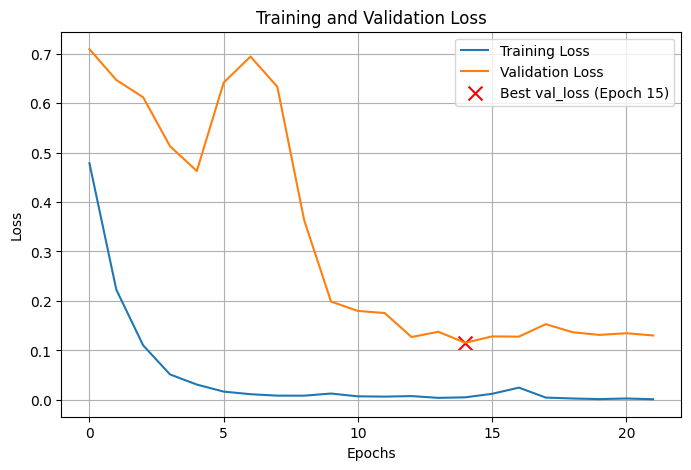

In [16]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

actual_epochs = len(loss)
epochs_range = range(actual_epochs)

plt.figure(figsize=(8, 5)) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

best_epoch = np.argmin(val_loss)
plt.scatter(best_epoch, val_loss[best_epoch], s=100, c='red', marker='x', label=f'Best val_loss (Epoch {best_epoch+1})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right') 
plt.grid(True)
plt.show()

In [17]:
val_ds_for_predict = create_dataset_val_test(val_df, BATCH_SIZE) 
y_pred_proba_val = model.predict(val_ds_for_predict)

y_true_val = val_df['class'].astype(int).values
print(f"Predictions count: {len(y_pred_proba_val)}, True labels count: {len(y_true_val)}")

if len(y_pred_proba_val) != len(y_true_val):
    print(f"Warning: Predictions count ({len(y_pred_proba_val)}) does not match true labels count ({len(y_true_val)}). Possibly due to drop_remainder=True.")
    y_true_val = y_true_val[:len(y_pred_proba_val)]
    print(f"True labels count adjusted to: {len(y_true_val)}")

# calculate Precision, Recall, and Thresholds 
print("Calculating Precision, Recall, and Thresholds...")
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_proba_val)

# calculate F1 score and find the Optimal Threshold 
f1_scores = np.array([2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision[:-1], recall[:-1])])

best_f1_idx = np.argmax(f1_scores)
if best_f1_idx >= len(thresholds):
     best_f1_idx = len(thresholds) - 1

best_threshold_f1 = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]
best_precision_f1 = precision[best_f1_idx]
best_recall_f1 = recall[best_f1_idx]

print(f"\nBest F1-score Threshold: {best_threshold_f1:.4f}")
print(f"  - F1-score: {best_f1:.4f}")
print(f"  - Precision at this threshold: {best_precision_f1:.4f}")
print(f"  - Recall at this threshold: {best_recall_f1:.4f}")

target_recall = 0.85
recall_indices = np.where(recall[:-1] >= target_recall)[0]

if len(recall_indices) > 0:
    best_f1_for_recall_local_idx = np.argmax(f1_scores[recall_indices])
    best_threshold_recall_idx_global = recall_indices[best_f1_for_recall_local_idx]

    if best_threshold_recall_idx_global >= len(thresholds):
        best_threshold_recall_idx_global = len(thresholds) - 1

    best_threshold_recall = thresholds[best_threshold_recall_idx_global]
    best_precision_recall = precision[best_threshold_recall_idx_global]
    actual_recall_recall = recall[best_threshold_recall_idx_global]
    f1_recall = f1_scores[best_threshold_recall_idx_global]

    print(f"\nSuggested Threshold for Recall >= {target_recall}: {best_threshold_recall:.4f}")
    print(f"  - Precision at this threshold: {best_precision_recall:.4f}")
    print(f"  - Actual Recall at this threshold: {actual_recall_recall:.4f}")
    print(f"  - F1-score at this threshold: {f1_recall:.4f}")
else:
    print(f"\nNo threshold found for Recall >= {target_recall}")
    best_threshold_recall = best_threshold_f1


chosen_threshold = min(best_threshold_recall, 0.5)

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step
Predictions count: 1355, True labels count: 1355
Calculating Precision, Recall, and Thresholds...

Best F1-score Threshold: 0.4494
  - F1-score: 0.9502
  - Precision at this threshold: 0.9567
  - Recall at this threshold: 0.9438

Suggested Threshold for Recall >= 0.85: 0.4494
  - Precision at this threshold: 0.9567
  - Actual Recall at this threshold: 0.9438
  - F1-score at this threshold: 0.9502


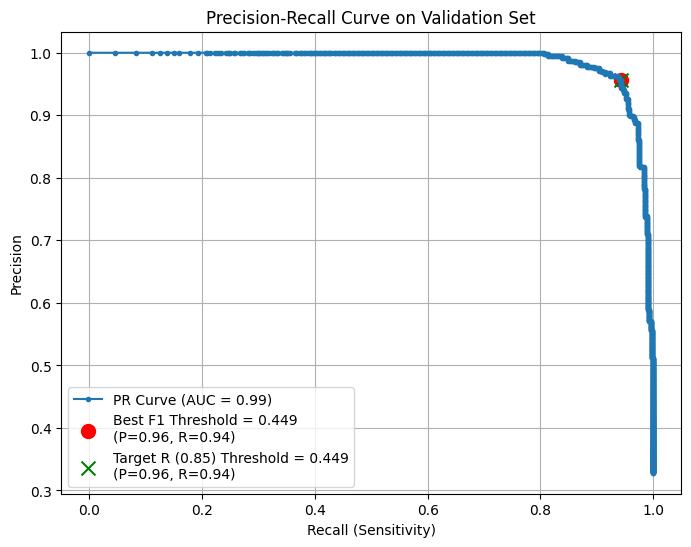

In [18]:
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', s=100, color='red', label=f'Best F1 Threshold = {best_threshold_f1:.3f}\n(P={best_precision_f1:.2f}, R={best_recall_f1:.2f})')

if len(recall_indices) > 0:
     plt.scatter(actual_recall_recall, best_precision_recall, marker='x', color='green', s=100, label=f'Target R ({target_recall}) Threshold = {best_threshold_recall:.3f}\n(P={best_precision_recall:.2f}, R={actual_recall_recall:.2f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Validation Set')
plt.legend()
plt.grid(True)
plt.show()


Classification Report (Validation - Adjusted Threshold):
               precision    recall  f1-score   support

No Stroke (0)       0.97      0.98      0.98       910
   Stroke (1)       0.96      0.94      0.95       445

     accuracy                           0.97      1355
    macro avg       0.96      0.96      0.96      1355
 weighted avg       0.97      0.97      0.97      1355



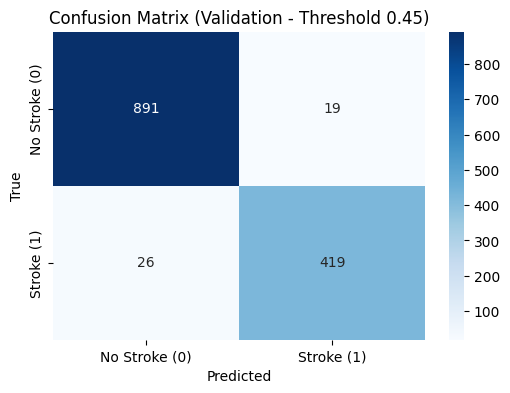

In [19]:
y_pred_val_adjusted = (y_pred_proba_val.flatten() > chosen_threshold).astype(int)

print("\nClassification Report (Validation - Adjusted Threshold):")
print(classification_report(y_true_val, y_pred_val_adjusted, target_names=['No Stroke (0)', 'Stroke (1)']))

cm_val_adjusted = confusion_matrix(y_true_val, y_pred_val_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke (0)', 'Stroke (1)'],
            yticklabels=['No Stroke (0)', 'Stroke (1)'])
plt.title(f'Confusion Matrix (Validation - Threshold {chosen_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
png_files = glob.glob(os.path.join('/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/PNG/*.png'))
png_filenames = [os.path.basename(f) for f in png_files]  

cevaplar_path = os.path.join('/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/ASAMA1_Cevaplar.txt')
labels_dict = {}

with open(cevaplar_path, 'r') as f:
    lines = f.readlines()[1:]  
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            image_id, label = parts
            filename = f"{image_id}.png"
            labels_dict[filename] = label

In [21]:
test_images = []
test_labels = []

for png_file in png_files:
    filename = os.path.basename(png_file)
    if filename in labels_dict:
        test_images.append(png_file)  
        test_labels.append(labels_dict[filename])

test_data = pd.DataFrame({
    'filename': test_images,
    'class': test_labels
})
test_data['class'] = test_data['class'].astype(str)

print("sample in test_data:", len(test_data))

sample in test_data: 200


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step
Predictions count: 200, True labels count: 200
Applying threshold: 0.45

Classification Report on Test Set:
               precision    recall  f1-score   support

No Stroke (0)     0.9338    0.9769    0.9549       130
   Stroke (1)     0.9531    0.8714    0.9104        70

     accuracy                         0.9400       200
    macro avg     0.9435    0.9242    0.9327       200
 weighted avg     0.9406    0.9400    0.9393       200



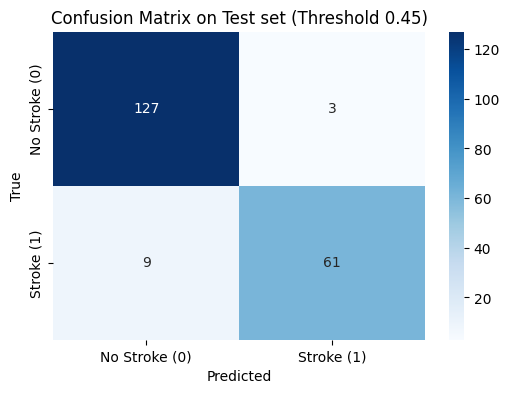

In [22]:
png_files = glob.glob(os.path.join('/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/PNG/*.png'))
png_filenames = [os.path.basename(f) for f in png_files]

cevaplar_path = os.path.join('/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/ASAMA1_Cevaplar.txt')
labels_dict = {}

with open(cevaplar_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[1:] 
    for line in lines:
        parts = [part.strip() for part in line.strip().split('\t')]
        if len(parts) == 2 and parts[0] and parts[1]: 
            image_id, label = parts
            filename = f"{image_id}.png"
            labels_dict[filename] = label

test_images = []
test_labels = []

for png_file in png_files:
    filename = os.path.basename(png_file)
    if filename in labels_dict:
        test_images.append(png_file)
        test_labels.append(labels_dict[filename])

test_data = pd.DataFrame({
    'filename': test_images,
    'class': test_labels
})
test_data['class'] = test_data['class'].astype(int)

test_ds = create_dataset_val_test(test_data, BATCH_SIZE)

y_pred_proba_test = model.predict(test_ds)

y_true_test = test_data['class'].values
print(f"Predictions count: {len(y_pred_proba_test)}, True labels count: {len(y_true_test)}")

y_true_test = y_true_test[:len(y_pred_proba_test)]

# Apply chosen threshold
print(f"Applying threshold: {chosen_threshold:.2f}")
y_pred_test = (y_pred_proba_test.flatten() > chosen_threshold).astype(int)

print("\nClassification Report on Test Set:")
if len(np.unique(y_true_test)) < 2 or len(np.unique(y_pred_test)) < 2:
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    print("\nConfusion Matrix on Test Set:")
    print(cm_test)
else:
    print(classification_report(y_true_test, y_pred_test, target_names=['No Stroke (0)', 'Stroke (1)'], digits = 4))

cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke (0)', 'Stroke (1)'],
            yticklabels=['No Stroke (0)', 'Stroke (1)'])
plt.title(f'Confusion Matrix on Test set (Threshold {chosen_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()